In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score
import lightgbm as lgb
import keras

import tensorflow as tf
import tensorflow_decision_forests as tfdf

import nltk
import gensim
import pickle

import warnings 
warnings.filterwarnings("ignore")

In [23]:
with open('X_train_reduced.pkl', 'rb') as handle:
    X_train_reduced = pickle.load(handle)
with open('X_val_reduced.pkl', 'rb') as handle:
    X_val_reduced = pickle.load(handle)
with open('X_test_reduced.pkl', 'rb') as handle:
    X_test_reduced = pickle.load(handle)
    
with open("y_train.pkl", 'rb') as handle:
    y_train = pickle.load(handle)
with open("y_val.pkl", 'rb') as handle:
    y_val = pickle.load(handle)
with open("y_test.pkl", 'rb') as handle:
    y_test = pickle.load(handle)

# Logistic Regression 

In [125]:
def build_lr_model(X_train, y_train, learning_rate=0.01, random_state = 1234, epochs = 100):
    """Build a TF logistic regression model using Keras.

    Inputs:
        X_train (array): training data to train logistic regression model, 
                        should be doc2vec embedding 
        y_train (array): test data to train logistic regression model
        learning_rate: The desired learning rate for Adam.
        epochs (int): number of training iterations 
        random_state (int): set random state for reproducibility
    Outputs:
        model (tensorflow model): A tensorflow keras
        history (tensorflow history): training history 
 
    """
    tf.keras.backend.clear_session()
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 
    
    # Build a model using keras.Sequential.
    model = tf.keras.Sequential()

    # Keras layers can do pre-processing. This layer will take 100x100 embeddings
    # and flatten them into vectors of size 10000.
    model.add(tf.keras.layers.Flatten())

    # This layer constructs the linear set of parameters for each input feature
    # (as well as a bias), and applies a sigmoid to the result. The result is
    # binary logistic regression.
    model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="sigmoid"         # apply the sigmoid function!
    ))

    # Use the Adam optimizer.
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', 
                optimizer=optimizer, 
                metrics=["accuracy"])
    history = model.fit(
        x = X_train,
        y = y_train,
        validation_split=0.2, 
        epochs=epochs, 
        callbacks=[callback])
    return model, history


## Doc2Vec

In [126]:
sc_x = StandardScaler()
X_train_sent_embedded_scaled = sc_x.fit(X_train_sent_embedded).transform(X_train_sent_embedded)

In [127]:
models_d2v = []
histories_d2v = []
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]

for lr in learning_rates: 
    print(f"\nTraining Learning Rate: {lr}")
    model, history = build_lr_model(X_train_sent_embedded_scaled, y_train, learning_rate = lr)
    models_d2v.append(model)
    histories_d2v.append(history)


Training Learning Rate: 0.0001
Epoch 1/100
3482/3482 [==============================] - 8s 2ms/step - loss: 0.6092 - accuracy: 0.6998 - val_loss: 0.5056 - val_accuracy: 0.7627
Epoch 2/100
3482/3482 [==============================] - 8s 2ms/step - loss: 0.4593 - accuracy: 0.7929 - val_loss: 0.4304 - val_accuracy: 0.8109
Epoch 3/100
3482/3482 [==============================] - 8s 2ms/step - loss: 0.4087 - accuracy: 0.8253 - val_loss: 0.3997 - val_accuracy: 0.8302
Epoch 4/100
3482/3482 [==============================] - 8s 2ms/step - loss: 0.3865 - accuracy: 0.8394 - val_loss: 0.3845 - val_accuracy: 0.8400
Epoch 5/100
3482/3482 [==============================] - 9s 3ms/step - loss: 0.3749 - accuracy: 0.8456 - val_loss: 0.3760 - val_accuracy: 0.8460
Epoch 6/100
3482/3482 [==============================] - 8s 2ms/step - loss: 0.3682 - accuracy: 0.8500 - val_loss: 0.3707 - val_accuracy: 0.8480
Epoch 7/100
3482/3482 [==============================] - 7s 2ms/step - loss: 0.3638 - accuracy: 0.

3482/3482 [==============================] - 6s 2ms/step - loss: 0.3666 - accuracy: 0.8530 - val_loss: 0.3687 - val_accuracy: 0.8564
Epoch 7/100
3482/3482 [==============================] - 6s 2ms/step - loss: 0.3671 - accuracy: 0.8525 - val_loss: 0.3704 - val_accuracy: 0.8501

Training Learning Rate: 0.1
Epoch 1/100
3482/3482 [==============================] - 7s 2ms/step - loss: 0.5439 - accuracy: 0.8214 - val_loss: 0.6034 - val_accuracy: 0.8214
Epoch 2/100
3482/3482 [==============================] - 6s 2ms/step - loss: 0.5552 - accuracy: 0.8196 - val_loss: 0.5162 - val_accuracy: 0.8321
Epoch 3/100
3482/3482 [==============================] - 6s 2ms/step - loss: 0.5548 - accuracy: 0.8201 - val_loss: 0.5473 - val_accuracy: 0.8156
Epoch 4/100
3482/3482 [==============================] - 6s 2ms/step - loss: 0.5568 - accuracy: 0.8201 - val_loss: 0.5735 - val_accuracy: 0.8107
Epoch 5/100
3482/3482 [==============================] - 6s 2ms/step - loss: 0.5545 - accuracy: 0.8199 - val_loss

In [128]:
model_d2v_lr = models_d2v[1]
model_d2v_lr.save("model_d2v_lr.keras")

In [114]:
 
def build_nn(X_train, y_train, hidden_layers = [], epochs = 20, random_state = 1234):
    '''
    Function to generalize neural network training
    
    Inputs:
        X_train (array): training data to train model, should doc2vec embedding 
        y_train (array): test data to train model
        hidden_layer (list): list of nodes to use for each new layer in neural network 
        epochs (int): number of training iterations 
        random_state (int): set random state for reproducibility
    Outputs:
        model (tensorflow model): A tensorflow keras
        history (tensorflow history): training history 
    
    '''
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_state)
    #Add early stopping to prevent extreme overfitting
    #If validation loss hasn't improved in 3 iterations, stop training 
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 
    
    model = tf.keras.Sequential()
    
    #Add more layers to neural network, each input in hidden_layer is additional layer 
    for nodes in hidden_layers:
        model.add(tf.keras.layers.Dense(nodes, activation = "relu"))
        model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

    model.compile(loss = "binary_crossentropy",
             optimizer = "adam", 
             metrics = ["accuracy"])
    
    #Fit the training and test dataset 
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
    history = model.fit(
        x = X_train,
        y = y_train,
        validation_split=0.2, 
        epochs=epochs, 
        callbacks=[callback])
    
    return model, history 

In [115]:
d2v_models_nn = []
d2v_histories_nn = [] 
hidden_layers = [[100], [100, 50], [50, 25], [100, 50, 25]]
for hidden_layer in hidden_layers: 
    print(hidden_layer)
    model, history = build_nn(X_train_sent_embedded, y_train, hidden_layers = hidden_layer)
    d2v_models_nn.append(model)
    d2v_histories_nn.append(history)
    

[100]
Epoch 1/20
3482/3482 [==============================] - 9s 2ms/step - loss: 0.3564 - accuracy: 0.8495 - val_loss: 0.3023 - val_accuracy: 0.8780
Epoch 2/20
3482/3482 [==============================] - 8s 2ms/step - loss: 0.3049 - accuracy: 0.8767 - val_loss: 0.2922 - val_accuracy: 0.8811
Epoch 3/20
3482/3482 [==============================] - 9s 2ms/step - loss: 0.2962 - accuracy: 0.8802 - val_loss: 0.2887 - val_accuracy: 0.8818
Epoch 4/20
3482/3482 [==============================] - 8s 2ms/step - loss: 0.2926 - accuracy: 0.8817 - val_loss: 0.2894 - val_accuracy: 0.8819
Epoch 5/20
3482/3482 [==============================] - 8s 2ms/step - loss: 0.2908 - accuracy: 0.8813 - val_loss: 0.2859 - val_accuracy: 0.8830
Epoch 6/20
3482/3482 [==============================] - 8s 2ms/step - loss: 0.2874 - accuracy: 0.8828 - val_loss: 0.2875 - val_accuracy: 0.8834
Epoch 7/20
3482/3482 [==============================] - 9s 2ms/step - loss: 0.2862 - accuracy: 0.8839 - val_loss: 0.2864 - val_acc

In [124]:
model_d2v_nn = d2v_models_nn[1]

model_d2v_nn.save("model_d2v_nn.keras")


In [ ]:

# with open('models_d2v.pkl', 'wb') as handle:
#     pickle.dump(models_d2v, handle)
# with open('histories_d2v.pkl', 'wb') as handle:
#     pickle.dump(histories_d2v, handle)

# Boosting

Unable to incorporate tensorflow random forest/boosted trees model with tensorflow Sequential model, use LightGBM for runtime. 
Light GBM is different than traditional Gradient Boosted Trees in that it grows leaf first instead of level first, allowing it to train much faster.

References: 
- https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

- https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#deal-with-over-fitting

- https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm-tuning.html

## Avg Word Embeddings and Doc2Vec Embeddings

Word embeddings are 2D arrays, take the average of the embeddings across each embedding index to flatten into 1D array, concatenate with 1D Doc2Vec embeddings in case DocwVec embeddings capture some information not already captured in the word embeddings

In [4]:
#Original word embeddings
with open('X_train_word_embedded.pkl', 'rb') as handle:
    X_train_word_embedded = pickle.load(handle)
with open('X_val_word_embedded.pkl', 'rb') as handle:
    X_val_word_embedded = pickle.load(handle)
with open('X_test_word_embedded.pkl', 'rb') as handle:
    X_test_word_embedded = pickle.load(handle)

In [5]:
#1D CNN word embeddings
with open('X_train_cnn_word_embedded.pkl', 'rb') as handle:
    X_train_cnn_word_embedded = pickle.load(handle)
with open('X_val_cnn_word_embedded.pkl', 'rb') as handle:
    X_val_cnn_word_embedded = pickle.load(handle)
with open('X_test_cnn_word_embedded.pkl', 'rb') as handle:
    X_test_cnn_word_embedded = pickle.load(handle)

In [6]:
#Word2Vec embeddings
with open('d2v_train.pkl', 'rb') as handle:
    X_train_sent_embedded = pickle.load(handle)
with open('d2v_val.pkl', 'rb') as handle:
    X_val_sent_embedded = pickle.load(handle)
with open('d2v_test.pkl', 'rb') as handle:
    X_test_sent_embedded = pickle.load(handle)


In [7]:
X_train_word_embedded_avg = np.array([np.mean(i, axis = 0) for i in X_train_word_embedded])
X_val_word_embedded_avg = np.array([np.mean(i, axis = 0) for i in X_val_word_embedded])
X_test_word_embedded_avg = np.array([np.mean(i, axis = 0) for i in X_test_word_embedded])

X_train_concatenated = np.concatenate((X_train_word_embedded_avg, X_train_sent_embedded), axis = 1)
X_val_concatenated = np.concatenate((X_val_word_embedded_avg, X_val_sent_embedded), axis = 1)
X_test_concatenated = np.concatenate((X_test_word_embedded_avg, X_test_sent_embedded), axis = 1)


In [8]:
X_train_cnn_word_embedded_avg = np.array([np.mean(i, axis = 0) for i in X_train_cnn_word_embedded])
X_val_cnn_word_embedded_avg = np.array([np.mean(i, axis = 0) for i in X_val_cnn_word_embedded])
X_test_cnn_word_embedded_avg = np.array([np.mean(i, axis = 0) for i in X_test_cnn_word_embedded])

X_train_cnn_concatenated = np.concatenate((X_train_cnn_word_embedded_avg, X_train_sent_embedded), axis = 1)
X_val_cnn_concatenated = np.concatenate((X_val_cnn_word_embedded_avg, X_val_sent_embedded), axis = 1)
X_test_cnn_concatenated = np.concatenate((X_test_cnn_word_embedded_avg, X_test_sent_embedded), axis = 1)


In [9]:
X_train_all_concatenated = np.concatenate((X_train_word_embedded_avg, X_train_cnn_word_embedded_avg, X_train_sent_embedded), axis = 1)
X_val_all_concatenated = np.concatenate((X_val_word_embedded_avg, X_val_cnn_word_embedded_avg, X_val_sent_embedded), axis = 1)
X_test_all_concatenated = np.concatenate((X_test_word_embedded_avg, X_test_cnn_word_embedded_avg, X_test_sent_embedded), axis = 1)


## Grid Search

In [10]:
n_estimators = [2000] #Set to large number, set early stopping rounds
learning_rate = [0.01] 
num_leaves = [15, 30, 50, 70] #tree grows leaf wise instead of depth wise for lightgbm, focus on tuning num leaves
min_child_samples = [100] #set number of entries needed in a leaf to prevent overfitting, set to 100 since data is large
reg_alpha = [0.1, 0.2, 0.3] #combined averaged word2vec embeddings with doc2vec embedding, so could be redundancy, set L1 regularization to drop out unnecessary features
early_stopping_rounds = [50]
random_state = [42]

param_grid = {"n_estimators": n_estimators,
              "learning_rate": learning_rate,
              "num_leaves": num_leaves,
              "min_child_samples": min_child_samples,
              "reg_alpha": reg_alpha,
              "early_stopping_rounds": early_stopping_rounds,
              "random_state": random_state}

In [38]:
lgb_model = lgb.LGBMClassifier()
grid_search = GridSearchCV(estimator = lgb_model, param_grid = param_grid, cv = 5,
                          n_jobs = -1, verbose = 2, scoring = "f1") 
grid_search.fit(X_train_concatenated, y_train, eval_set = [(X_val_concatenated, y_val)], eval_metric = "logloss")
grid_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 69639, number of negative: 69604
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 139243, number of used features: 200
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000503
[LightGBM] [Info] Start training from score 0.000503
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[446]	valid_0's binary_logloss: 0.204129


{'early_stopping_rounds': 50,
 'learning_rate': 0.01,
 'min_child_samples': 100,
 'n_estimators': 2000,
 'num_leaves': 50,
 'random_state': 42,
 'reg_alpha': 0.3}

In [41]:
lgb_model = grid_search.best_estimator_

In [56]:
#with open('models_lgb.pkl', 'wb') as handle:
#    pickle.dump(lgb_model, handle)

In [11]:
lgb_model_cnn = lgb.LGBMClassifier()
grid_search_cnn = GridSearchCV(estimator = lgb_model_cnn, param_grid = param_grid, cv = 5,
                          n_jobs = -1, verbose = 2, scoring = "f1") 
grid_search_cnn.fit(X_train_cnn_concatenated, y_train, eval_set = [(X_val_cnn_concatenated, y_val)], eval_metric = "logloss")
grid_search_cnn.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 69639, number of negative: 69604
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.265218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 139243, number of used features: 200
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000503
[LightGBM] [Info] Start training from score 0.000503
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1240]	valid_0's binary_logloss: 0.202364


{'early_stopping_rounds': 50,
 'learning_rate': 0.01,
 'min_child_samples': 100,
 'n_estimators': 2000,
 'num_leaves': 50,
 'random_state': 42,
 'reg_alpha': 0.3}

In [12]:
lgb_model_cnn = grid_search_cnn.best_estimator_

In [13]:
# with open('models_lgb_cnn.pkl', 'wb') as handle:
#     pickle.dump(lgb_model_cnn, handle)

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 55711, number of negative: 55683
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.826477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 111394, number of used features: 200
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000503
[LightGBM] [Info] Start training from score 0.000503
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.202596
[CV] END early_stopping_rounds=50, learning_rate=0.01, min_child_samples=100, n_est

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 55711, number of negative: 55683
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.851098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 111394, number of used features: 200
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000503
[LightGBM] [Info] Start training from score 0.000503
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.202411
[CV] END early_stopping_rounds=50, learning_rate=0.01, min_child_samples=100, n_est

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 55712, number of negative: 55683
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.777558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 111395, number of used features: 200
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500130 -> initscore=0.000521
[LightGBM] [Info] Start training from score 0.000521
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.202942
[CV] END early_stopping_rounds=50, learning_rate=0.01, min_child_samples=100, n_est

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 55711, number of negative: 55683
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.829839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 111394, number of used features: 200
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000503
[LightGBM] [Info] Start training from score 0.000503
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1979]	valid_0's binary_logloss: 0.203056
[CV] END early_stopping_rounds=50, learning_rate=0.01, min_child_samples=100, n_est

# Model Results

In [130]:
model_d2v_lr = tf.keras.models.load_model("model_d2v_lr.keras")
model_d2v_nn = tf.keras.models.load_model("model_d2v_nn.keras")
model_we = tf.keras.models.load_model("model_word_embedding.keras")
model_cnn = tf.keras.models.load_model("model_cnn_1.keras")

In [186]:
model_we.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         484500    
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                        

In [187]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         484500    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         51328     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          32832     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                        

In [131]:
with open('models_lgb.pkl', 'rb') as handle:
    model_lgb_we = pickle.load(handle)
with open('models_lgb_cnn.pkl', 'rb') as handle:
    model_lgb_cnn = pickle.load(handle)


In [144]:
we_preds = model_we.predict(X_val_reduced).flatten()
cnn_preds = model_cnn.predict(X_val_reduced).flatten()
sc_x = StandardScaler()
d2v_lr_preds = model_d2v_lr.predict(sc_x.fit(X_train_sent_embedded).transform(X_val_sent_embedded)).flatten()
d2v_nn_preds = model_d2v_nn.predict(X_val_sent_embedded).flatten()
lgb_we_preds = model_lgb_we.predict_proba(X_val_concatenated)[:, 1]
lgb_cnn_preds = model_lgb_cnn.predict_proba(X_val_cnn_concatenated)[:, 1]

we_preds_test = model_we.predict(X_test_reduced).flatten()
cnn_preds_test = model_cnn.predict(X_test_reduced).flatten()
sc_x = StandardScaler()
d2v_lr_preds_test = model_d2v_lr.predict(sc_x.fit(X_train_sent_embedded).transform(X_test_sent_embedded)).flatten()
d2v_nn_preds_test = model_d2v_nn.predict(X_test_sent_embedded).flatten()
lgb_we_preds_test = model_lgb_we.predict_proba(X_test_concatenated)[:, 1]
lgb_cnn_preds_test = model_lgb_cnn.predict_proba(X_test_cnn_concatenated)[:, 1]


we_preds_int = np.round(we_preds).astype(int)
cnn_preds_int = np.round(cnn_preds).astype(int)
d2v_lr_preds_int = np.round(d2v_lr_preds).astype(int)
d2v_nn_preds_int = np.round(d2v_nn_preds).astype(int)
lgb_we_preds_int = np.round(lgb_we_preds).astype(int)
lgb_cnn_preds_int = np.round(lgb_we_preds).astype(int)

we_preds_test_int = np.round(we_preds_test).astype(int)
cnn_preds_test_int = np.round(cnn_preds_test).astype(int)
d2v_lr_preds_test_int = np.round(d2v_lr_preds_test).astype(int)
d2v_nn_preds_test_int = np.round(d2v_nn_preds_test).astype(int)
lgb_we_preds_test_int = np.round(lgb_we_preds_test).astype(int)
lgb_cnn_preds_test_int = np.round(lgb_we_preds_test).astype(int)

1451/1451 [==============================] - 2s 1ms/step


In [145]:
embedding_val_preds = pd.DataFrame({"Word Embedding Preds": we_preds,
                                 "CNN Embedding Preds": cnn_preds,
                                 "Doc2Vec LR Preds": d2v_lr_preds,
                                 "Doc2Vec NN Preds": d2v_nn_preds,   
                                 "Word Embedding LGB Preds": lgb_we_preds,
                                 "CNN Embedding LGB Preds": lgb_cnn_preds})
embedding_test_preds = pd.DataFrame({"Word Embedding Preds": we_preds_test,
                                 "CNN Embedding Preds": cnn_preds_test,
                                 "Doc2Vec LR Preds": d2v_lr_preds_test,
                                 "Doc2Vec NN Preds": d2v_nn_preds_test,
                                 "Word Embedding LGB Preds": lgb_we_preds_test,
                                 "CNN Embedding LGB Preds": lgb_cnn_preds_test})
with open("embedding_val_preds.pkl", "wb") as handle:
    pickle.dump(embedding_val_preds, handle)
with open("embedding_test_preds.pkl", "wb") as handle:
    pickle.dump(embedding_test_preds, handle)

In [190]:
print(classification_report(y_test, we_preds_test_int))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     23248
           1       0.92      0.92      0.92     23167

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415



In [192]:
print(classification_report(y_test, cnn_preds_test_int))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     23248
           1       0.91      0.94      0.92     23167

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415



In [193]:
print(classification_report(y_test, d2v_lr_preds_test_int))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85     23248
           1       0.89      0.79      0.84     23167

    accuracy                           0.85     46415
   macro avg       0.85      0.85      0.85     46415
weighted avg       0.85      0.85      0.85     46415



In [194]:
print(classification_report(y_test, d2v_nn_preds_test_int))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     23248
           1       0.89      0.87      0.88     23167

    accuracy                           0.88     46415
   macro avg       0.88      0.88      0.88     46415
weighted avg       0.88      0.88      0.88     46415



In [195]:
test_results = pd.DataFrame({"Actual": y_test,
                           "Word Embedding": we_preds_test_int,
                           "1D CNN": cnn_preds_test_int, 
                           "Sentence Embedding": d2v_nn_preds_test_int})
d2v_correct_over_others = test_results[(test_results["Sentence Embedding"] != test_results["Word Embedding"]) & 
           (test_results["Sentence Embedding"] != test_results["1D CNN"]) & 
           (test_results["Sentence Embedding"] == test_results["Actual"])]
print("% of d2v predictions correct over other models:\n", round(d2v_correct_over_others.shape[0]/test_results.shape[0] * 100, 2))
print("Class of d2v predictions that are correct over other models:\n", d2v_correct_over_others["Actual"].value_counts(normalize = True))

% of d2v predictions correct over other models:
 1.54
Class of d2v predictions that are correct over other models:
 Actual
0    0.645161
1    0.354839
Name: proportion, dtype: float64


The original word embeddings model is very consistent across all the metrics, scoring around 92% across all metrics on the validation set. The embeddings created with 1D convolutional neural network have the same F1 score as the original word embeddings, however, there is slight variations in precision and recall. The 1D CNN has slightly higher precision / lower recall for non-suicide and the reverse for the suicide class. The 1D CNN model is slightly more conservative with predicting non-suicide class, but in doing so is more accurate in predicting them. The Doc2Vec embedding neural network model has a lower score on all metrics. It tends to be more conservative predicting a class as suicide (indicated with a lower recall score). In doing so, of the entries that the Doc2Vec neural network predicts correctly over the word embedding models, 2/3 of them are from the non-suicide class. 

In [196]:
print(classification_report(y_test, lgb_we_preds_test_int))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     23248
           1       0.92      0.93      0.93     23167

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415



In [197]:
print(classification_report(y_test, lgb_cnn_preds_test_int))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     23248
           1       0.92      0.93      0.93     23167

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415



LGB Preds same: 1.0


<Axes: >

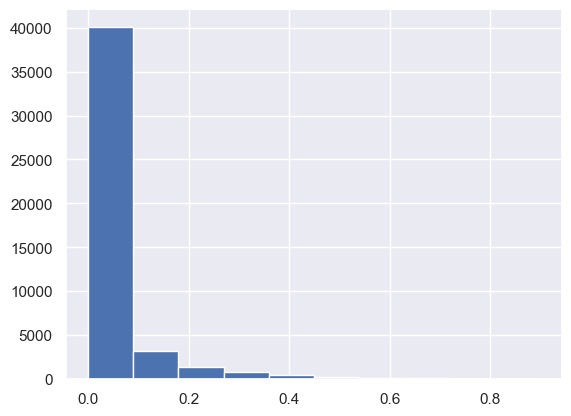

In [200]:
print("LGB Preds same:", sum(lgb_cnn_preds_test_int == lgb_we_preds_test_int)/lgb_we_preds_test_int.shape[0])
pd.Series(abs(lgb_we_preds_test - lgb_cnn_preds_test)).hist()

In [201]:
print("Diff < 10%:", sum(abs(lgb_we_preds_test - lgb_cnn_preds_test) < 0.1)/lgb_we_preds_test.shape[0])
print("Diff 10-20%:", sum((abs(lgb_we_preds_test - lgb_cnn_preds_test) >= 0.1) & 
                         (abs(lgb_we_preds_test - lgb_cnn_preds_test) < 0.2))/lgb_we_preds_test.shape[0])
print("Diff 20-30%:", sum((abs(lgb_we_preds_test - lgb_cnn_preds_test) >= 0.2) & 
                         (abs(lgb_we_preds_test - lgb_cnn_preds_test) < 0.3))/lgb_we_preds_test.shape[0])

print("Diff 30+%:", sum((abs(lgb_we_preds_test - lgb_cnn_preds_test) >= 0.3))/lgb_we_preds_test.shape[0])


Diff < 10%: 0.876613163847894
Diff 10-20%: 0.06603468706237207
Diff 20-30%: 0.02757729182376387
Diff 30+%: 0.029774857265970053


Both the boosting model yield the same predictions, and looking at the prediction probabilities, 87% of the predicted probabilities are within 10% of each other.